# RNNs and LSTMs:




#### A few imports and functions before we get started

In [ ]:
!pip install pycm livelossplot
%pylab inline

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 64 kB 871 kB/s 
     |████████████████████████████████| 595 kB 29.7 MB/s 
Populating the interactive namespace from numpy and matplotlib


In [ ]:
import random
import time
import math

import glob
import string
import unicodedata
import re
from collections import Counter

import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import TensorDataset, DataLoader
from torch.autograd import Variable
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

from livelossplot import PlotLosses

import pandas as pd


def set_seed(seed):
    """
    Use this to set ALL the random seeds to a fixed value and take out any randomness from cuda kernels
    """
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)

    torch.backends.cudnn.benchmark = False  # uses the inbuilt cudnn auto-tuner to find the fastest convolution algorithms. -
    torch.backends.cudnn.enabled   = False

    return True

device = 'cpu'
if torch.cuda.device_count() > 0 and torch.cuda.is_available():
    print("Cuda installed! Running on GPU!")
    print(torch.cuda.get_device_name())
    device = 'cuda'
else:
    print("No GPU available! Running on CPU")

Cuda installed! Running on GPU!
Tesla T4


#### Mounting the google drive for storage

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


## Word-level text generation with RNNs


[Let's see if you can differentiate between machine generated text and human written text.](http://goopt2.xyz/)


We will use RNNs to build our generator network but you can also consider using LSTMs, which have a gating mechanism that allows information to continue flowing into the layers and cells of the network and have been showed to outperform vanilla RNNs for text generation.

### Downloading the data and some utility functions

In [ ]:
# download the data
!mkdir data_gen
!cd data_gen && wget https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv

filename = 'data_gen/reddit-cleanjokes.csv'

--2022-12-08 14:03:11--  https://raw.githubusercontent.com/amoudgl/short-jokes-dataset/master/data/reddit-cleanjokes.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.111.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.111.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 141847 (139K) [text/plain]
Saving to: ‘reddit-cleanjokes.csv’

reddit-cleanjokes.c 100%[===================>] 138.52K  --.-KB/s    in 0.02s   

2022-12-08 14:03:11 (8.29 MB/s) - ‘reddit-cleanjokes.csv’ saved [141847/141847]



#### Function to read the lines of a file as a list of words

In [ ]:
def readFile_csv(filename, header):
    """ 
    Read a csv file and return list with line entries 
    """
    dataframe = pd.read_csv(filename)
    data = dataframe[header].str.cat(sep=' ')
    data = data.split(' ')
    return data

filename, header = 'data_gen/reddit-cleanjokes.csv', 'Joke'
data = readFile_csv(filename, header)
print((data))
print(len(data))

['What', 'did', 'the', 'bartender', 'say', 'to', 'the', 'jumper', 'cables?', 'You', 'better', 'not', 'try', 'to', 'start', 'anything.', "Don't", 'you', 'hate', 'jokes', 'about', 'German', 'sausage?', "They're", 'the', 'wurst!', 'Two', 'artists', 'had', 'an', 'art', 'contest...', 'It', 'ended', 'in', 'a', 'draw', 'Why', 'did', 'the', 'chicken', 'cross', 'the', 'playground?', 'To', 'get', 'to', 'the', 'other', 'slide.', 'What', 'gun', 'do', 'you', 'use', 'to', 'hunt', 'a', 'moose?', 'A', 'moosecut!', 'If', 'life', 'gives', 'you', 'melons,', 'you', 'might', 'have', 'dyslexia.', 'Broken', 'pencils...', '...are', 'pointless.', 'What', 'did', 'one', 'snowman', 'say', 'to', 'the', 'other', 'snowman?', "'Do", 'you', 'smell', "carrots?'", 'How', 'many', 'hipsters', 'does', 'it', 'take', 'to', 'change', 'a', 'lightbulb?', "It's", 'a', 'really', 'obscure', 'number.', "You've", 'probably', 'never', 'heard', 'of', 'it.', 'Where', 'do', 'sick', 'boats', 'go?', 'The', 'dock!', 'I', 'like', 'my', 'sla

#### Data inspection and some more utility functions

We use a counter from the collections module to create a dictionary where the words are stored as the keys and their counts are the values. You can read more about collections [here](https://docs.python.org/3/library/collections.html).

In [ ]:
word_counts = Counter(data)                                            # create a Counter for our data
uniq_words = sorted(word_counts, key=word_counts.get, reverse=True)    # find all unique words
print(uniq_words)                                                      # print the list of unique words
print(len(word_counts))                                                # print the number of unique words

['the', 'a', 'What', 'you', 'to', 'do', 'I', 'of', 'did', 'Why', 'in', 'and', 'was', 'A', 'call', 'it', 'is', 'with', 'his', 'Because', 'say', 'he', 'get', 'on', 'when', 'my', 'How', 'for', 'an', 'does', 'The', 'about', 'have', 'that', 'one', 'He', 'are', 'at', 'who', "What's", 'hear', 'from', 'into', 'out', 'be', 'this', 'they', 'had', 'like', "don't", 'your', 'Did', 'go', 'can', 'but', 'joke', "I'm", 'It', 'me', 'no', 'My', 'other', 'so', 'make', 'You', 'all', 'up', 'favorite', 'know', 'their', 'just', 'got', 'what', 'not', 'They', 'take', 'cross', 'two', 'many', 'Where', 'said', 'man', 'people', 'always', 'To', 'it.', "it's", 'fish', 'between', 'her', 'if', 'by', "couldn't", 'Two', 'little', "can't", 'too', 'has', 'kind', "It's", 'cow', '.', 'would', 'only', "didn't", 'think', 'walks', 'chicken', 'will', 'heard', 'there', 'much', 'were', 'says', 'made', 'If', 'told', 'went', 'So', 'best', 'really', 'difference', 'says,', 'because', '-', 'wanted', 'time', 'When', 'never', 'she', 'why

In [ ]:
word_to_index = {word: index for index, word in enumerate(uniq_words)} # create a word-to-index dictionary
index_to_word = {index: word for index, word in enumerate(uniq_words)} # create an index-to-word dictionary

words_indexes = [word_to_index[word] for word in data]                 # find the indices in all words in the dataset
print(words_indexes)                                                   # print the indices

[2, 8, 0, 248, 20, 4, 0, 1905, 1906, 64, 534, 73, 535, 4, 1907, 1908, 225, 3, 226, 227, 31, 249, 1909, 314, 0, 1910, 93, 704, 47, 28, 705, 1077, 57, 424, 10, 1, 347, 9, 8, 0, 107, 76, 0, 706, 84, 22, 4, 0, 61, 1911, 2, 1078, 5, 3, 133, 4, 1912, 1, 1913, 13, 1914, 115, 275, 1079, 3, 1915, 3, 348, 32, 1916, 1917, 1918, 1080, 1919, 2, 8, 34, 707, 20, 4, 0, 61, 708, 1920, 3, 425, 1921, 26, 78, 1081, 29, 15, 75, 4, 187, 1, 276, 99, 1, 120, 1082, 1922, 1083, 709, 128, 109, 7, 85, 79, 5, 349, 1084, 710, 30, 1923, 6, 48, 25, 1085, 48, 6, 48, 25, 1924, 1086, 60, 426, 116, 58, 129, 12, 1087, 58, 123, 6, 164, 1925, 4, 44, 1, 1926, 6, 174, 1088, 1927, 6, 53, 1928, 427, 711, 1929, 350, 38, 73, 351, 10, 1089, 712, 202, 34, 1930, 2, 8, 0, 1090, 7, 1, 1931, 713, 20, 24, 18, 713, 714, 715, 315, 165, 0, 1932, 1933, 1934, 2, 1091, 7, 1935, 1936, 3, 1937, 13, 1938, 1939, 1940, 1941, 1942, 7, 25, 1943, 1944, 1945, 2, 8, 0, 316, 133, 4, 1092, 139, 145, 1946, 13, 1947, 1948, 2, 8, 0, 316, 133, 4, 22, 43, 0, 


Our inputs will be the words of a chosen sequence length, and the outputs will be the next word.
We want to predict the next word from the current sequence of words, so we will create sequences, which are groups of consecutive words. 

For example, consider the sentence: **What did the bartender say to the jumper cables?**. For a chosen sequence length of 4:
- input sequence: ['What', 'did', 'the', 'bartender'] 
- target sequence: ['did', 'the', 'bartender', 'say'] 
The output sequence is always one time step ahead of the input, and the set of input and sequence sequence gives one data point.

In [ ]:
sequence_length= 4
index = 0
tensor_in = torch.tensor(words_indexes[index:index+sequence_length])
tensor_out = torch.tensor(words_indexes[index+1:index+sequence_length+1])

print(tensor_in)
print(tensor_out)

tensor([  2,   8,   0, 248])
tensor([  8,   0, 248,  20])


## Creating a custom TensorDataset that allows us to perform the following:
- Take as inputs a list of all words in our text
- Generate a dictionary of all unique words and their counts, sorted in descending order
- Return a sample of input and output data

In [ ]:
class WordsTensorDataset(TensorDataset):
    def __init__(self, data_list, sequence_length=4):
        """
        Args:
            data_list (dictionary): A list of all the words in the file
            sequence_length: the number of words in each input sample, and output sample
        """
        self.sequence_length = sequence_length
        self.data_list = data_list
        self.unique_words = self.get_unique_words()

        self.word_to_idx = {word: idx for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of words to indices
        self.idx_to_word = {idx: word for idx, word in enumerate(self.unique_words)}  # create a dictionary of mappings of indices to words     

        self.words_idxs = [self.word_to_idx[word] for word in data]                   # return a list of the dat with the words represented with their indices

    def get_unique_words(self):
        word_counts = Counter(self.data_list)
        return sorted(word_counts, key=word_counts.get, reverse=True)                 # return a list of the unique words sorted in ascending order

    def __len__(self):
        return len(self.words_idxs) - self.sequence_length

    def __getitem__(self, idx):

        sample_input = torch.tensor(self.words_idxs[idx:idx+self.sequence_length])       # get a sample input sequence
        sample_output = torch.tensor(self.words_idxs[idx+1:idx+self.sequence_length+1])  # get a sample output sequence

        return sample_input, sample_output

In [ ]:
words_dataset = WordsTensorDataset(data, sequence_length=4)
words_dataloader = DataLoader(words_dataset, batch_size=5, shuffle=False)

next(iter(words_dataloader))

[tensor([[   2,    8,    0,  248],
         [   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905]]), tensor([[   8,    0,  248,   20],
         [   0,  248,   20,    4],
         [ 248,   20,    4,    0],
         [  20,    4,    0, 1905],
         [   4,    0, 1905, 1906]])]

##Implementing a Text "Generator" Network with RNNs

We will use the pytorch built-in Embedding for this exercise. The [nn.Embedding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) enables us to encode words into a sort of look-up table. You will learn more about embeddings in the next lecture. 

To implement our RNN, we will start by creating an `nn.Module` that will represent a single RNN cell. This cell will update its hidden state by:

- Applying a linear, fully connected layer to the cell input.
- Applying a linear, fully connected layer to the previous hidden state.
- Applying a non-linear activation to the result.

In [ ]:
class RNNCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True, activation="tanh"):
        super(RNNCell, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # select appropriate activation function

        # create linear layer from input to hidden state
        # create linear layer from previous to current hidden state

        # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h):
        # map from input to hidden state space
        # map from previous to current hidden state space
        # calculate new hidden state by applying activation

        return h

Once we have implemented a single RNN cell, we can write another `nn.Module` for our RNN network: it will contain one or more cells, concatenated forming multiple layers, and will apply the RNN cells to a given input sequence.

The final output of the RNN will be obtained by applying a final fully connected layer to the last hidden state. 

In [ ]:
class RNN(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False, activation='tanh'):
        super(RNN, self).__init__()
        
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.bias = bias

        # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers

        # create a final linear layer from hidden state to network output
    
    def init_hidden(self,  batch_size=1):
        # initialise the hidden state

    def forward(self, input, h0):
        # Input of shape (batch_size, seqence length, input_size)
        # Output of shape (batch_size, output_size)

        batch_size = input.size(0)
        step_size = input.size(1)

        # iterate over all elements in the sequence
        for t in range(step_size):
            # iterate over each layer 
            for layer in range(self.num_layers):
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number

                # store the hidden state of each layer

            # the hidden state of the last layer needs to be recorded
            # to be used in the output

        # calculate output for each element in the sequence

        return out

We can now use out RNN network, together with the `nn.Embedding` to form our text-generating network.

In [ ]:
class RNN_GEN(nn.Module):

    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(RNN_GEN, self).__init__()

        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        
        # add a nn.Embedding
        # add our RNN

    def forward(self, x):
        # initialise hidden state
        
        # store the word embeddings
        # apply the RNN
        
        return output

def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

Define the train and evaluate functions:

In [ ]:
def train_rnn_gen(model, optimizer, criterion, dataloader):
    model.train()    # set model to train mode
    train_loss = 0   # initialise the loss
    
    # loop over dataset
        # send data to device
        # reset the gradients
        # get output
        
        # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)

        # backpropagate
        # update weights

    return train_loss/len(dataloader)


def predict_rnn_gen(dataset, model, text, next_words=100):
    model.eval()  # set model to evaluation mode

    words = text.split(' ')

    # loop over words
        # take word from dataset and send to device
        # compute output and hidden state
       
        # take last output

        # obtain probability vector for last output
        # sample probability vector to get index in dataset 

        # get word corresponding to dataset

    return ' '.join(words)


###Hyperparameters, model initialisation and the training loop

Let's train our network for a fixed number of epochs:

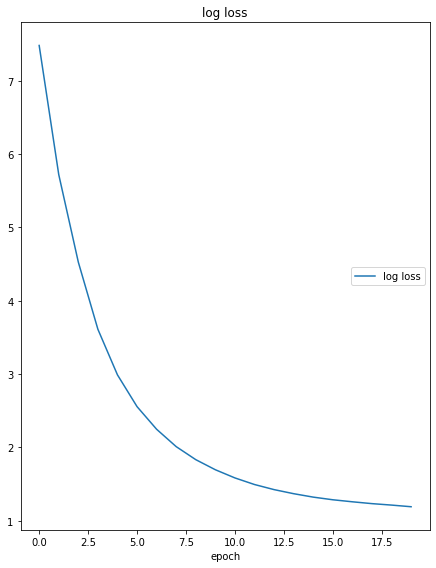

log loss
	log loss         	 (min:    1.191, max:    7.481, cur:    1.191)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 128
n_hidden = 128                         
n_layers = 1
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 256
sequence_length = 4

lr = 5e-3
momentum = 0.5
n_epochs = 20

rnn_gen = RNN_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(rnn_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(rnn_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)   

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_rnn_gen(rnn_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

#### Let's try predicting with our network

And, let's see how the network performs:

In [ ]:
print(predict_rnn_gen(words_dataset, rnn_gen, text='Knock knock. Whos there?', next_words=100))

Knock knock. Whos there? Well, not your parents, to a foreign country to get his sex change operation. Now he's a dude who's abroad. A vampire stopped afford What's a difference between a and King Arthur's table? Sir Cumference. I know a guy who collects to robin through deforestation of the Amazon? A Brazillionaire! Whats Marios favorite type of jeans? denim denim denim! What did the mom say to the tyrannical fruit? He was "I'll on hear a joke about pizza? Never mind it is too cheesy. What did the Triangle say to the other wall? I`ll meet you at the corner. What's the


##Implementing a Text "Generator" Network with LSTMs

Simple RNNs have trouble learning. For example, if we try to predict the last word in the sentence: There are so many clouds in the sky. This is easy for a simple RNN to predict as the necessary context word clouds appeared just two words ago.

However, look at the following example: I grew up in France... I speak fluent French. The distance between the contextual clue word France and the predicted word French could have been arbitrarily long in this text. Furthermore, the vanishing gradient and exploding gradient effects during backpropagation affect the performance of RNN. Given a very long sequence, information at the start of the sequence might have almost no impact at the end of the sequence.

Let's re-implement our previous example using an LSTM instead of a vanilla RNN. to do this, we need to start by implementing the LSTM cell. This cell will update both its hidden state and cell state by using the different gates that we have seen in class:

- Input gate
- Forget gate
- Output gate
- Candidate update

In [ ]:
class LSTMCell(nn.Module):

    def __init__(self, input_size, hidden_size, bias=True):
        super(LSTMCell, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.bias = bias

        # we will streamline the implementation of the LSTM by combining the
        # weights for all 4 operations (input gate, forget gate, output gate, candidate update)
        
        # create a linear layer to map from input to hidden space
        # create a linear layer to map from previous to current hidden space

        # initialise the parameters

    def reset_parameters(self):
        std = 1.0 / np.sqrt(self.hidden_size)

        for w in self.parameters():
            w.data.uniform_(-std, std)

    def forward(self, input, h, c):
        # apply the weights to both input and previous state

        # separate the output into each of the LSTM operations

        # apply the corresponding activations

        # calculate the next cell state

        # calculate the next hidden state

        return h, c


To construct a fully functional LSTM network, we create a similar `nn.Module` to the one used for the RNN, which will concatenate one or more LSTM cells and apply them to a given input sequence.

In [ ]:
class LSTM(nn.Module):

    def __init__(self, input_size, hidden_size, num_layers, output_size, bias=False):
        super(LSTM, self).__init__()

        self.input_size = input_size
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.bias = bias
        self.output_size = output_size

        # create a list of modules

        # create each layer in the network
        # take care when defining the input size of the first vs later layers

        # create a final linear layer from hidden state to network output

    def init_hidden(self,  batch_size=1):
        # initialise the hidden state and cell state

    def forward(self, input, h0, c0):
        # Input of shape (batch_size, seqence length , input_size)
        # Output of shape (batch_size, output_size)

        # iterate over all elements in the sequence
            # iterate over each layer
                # apply each layer
                # take care to apply the layer to the input or the
                # previous hidden state depending on the layer number

                # store the hidden and cell state of each layer

            # the hidden state of the last layer needs to be recorded
            # to be used in the output

        # calculate output for each element in the sequence

        return out

We can now substitute the RNN for an LSTM in our test-generation network:

In [ ]:
class LSTM_GEN(nn.Module):
    def __init__(self, input_size, embedding_dim, hidden_size, num_layers, num_unique_words):
        super(LSTM_GEN, self).__init__()

        # define your layers and activations
        self.input_size = input_size
        self.embedding_dim = embedding_dim
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        self.num_unique_words = num_unique_words
        self.batch_size = batch_size
        
        # add a nn.Embedding
        # add out LSTM

    def forward(self, x):
        batch_size = x.size(0)
        
        # initialise hidden state

        # store the word embeddings
        # apply the LSTM

        return output


def count_trainable_parameters(model):
    return sum([p.numel() for p in model.parameters() if p.requires_grad])

### The train and predict functions

In [ ]:
def train_lstm_gen(model, optimizer, criterion, dataloader):
    model.train()                       # set model to train mode
    train_loss, train_accuracy = 0, 0   # initialise the loss 
    
    for i, (x, y) in enumerate(dataloader):  # loop over dataset
        x, y = x.to(device), y.to(device)    # send data to device
        optimizer.zero_grad()                # reset the gradients
        y_pred = model(x)                    # get output and hidden state
        
        loss = criterion(y_pred.permute(0,2,1), y)  # compute the loss (change shape as crossentropy takes input as batch_size, number of classes, d1, d2, ...)
        train_loss += loss

        loss.backward()                      # backpropagate
        optimizer.step()                     # update weights 

    return train_loss/len(dataloader)


def predict_lstm_gen(dataset, model, text, next_words=10):
    model.eval()  # set model to evaluation mode

    words = text.split(' ')

    for i in range(next_words):  # loop over words
        x = torch.tensor([[dataset.word_to_idx[word] for word in words[i:]]]).to(device)  # take word from dataset and send to device
        y_pred = model(x)                                                                 # compute output and hidden state
       
        last_word_logits = y_pred[0][-1]                                                  # take last output
                  
        p = torch.nn.functional.softmax(last_word_logits, dim=0).detach().cpu().numpy()   # obtain probability vector for last output
        word_idx = np.random.choice(len(last_word_logits), p=p)                           # sample probability vector to get index in dataset    

        words.append(dataset.idx_to_word[word_idx])                                       # get word corresponding to dataset

    return ' '.join(words)

### Hyperparameters, model initialisation and training loop

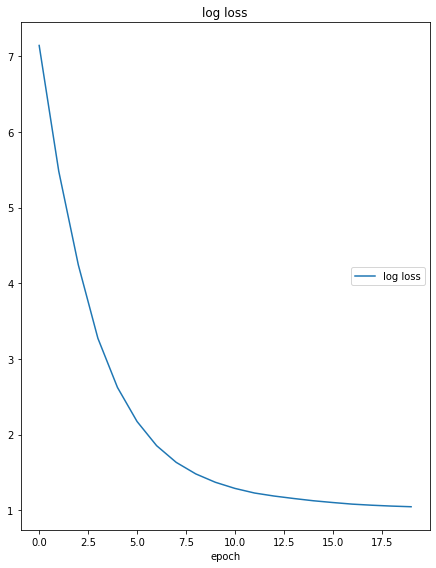

log loss
	log loss         	 (min:    1.047, max:    7.142, cur:    1.047)


In [ ]:
device = device = torch.device("cuda" if torch.cuda.is_available() else "cpu") 

input_size = 128
n_hidden = 128                         
n_layers = 1
embedding_dim = input_size
n_unique_words = len(words_dataset.unique_words)
batch_size = 128
sequence_length = 4

lr = 5e-3
momentum = 0.5
n_epochs = 20

lstm_gen = LSTM_GEN(input_size, embedding_dim, n_hidden, n_layers, n_unique_words).to(device)
print(f'The model has {count_trainable_parameters(lstm_gen):,} trainable parameters')

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(lstm_gen.parameters(), lr=lr)

words_dataset = WordsTensorDataset(data, sequence_length=sequence_length)
words_dataloader = DataLoader(words_dataset, batch_size=batch_size, shuffle=False)  

# Keep track of losses for plotting
liveloss = PlotLosses()
for epoch in range(n_epochs):
    logs = {}
    train_loss = train_lstm_gen(lstm_gen, optimizer, criterion, words_dataloader)

    print(epoch,train_loss)

    logs['' + 'log loss'] = train_loss.item()
    liveloss.update(logs)
    liveloss.draw()

Let's try to predict the next 

In [ ]:
print(predict_lstm_gen(words_dataset, lstm_gen, text='Knock knock. Whos there?', next_words=100))

Knock knock. Whos there? Yoda lady. Yoda lady who? Good job yodeling! 2.Knock knock. Whos there? Well, not your parents, because your parents never knock! What do you call a ubiquitous spud? A common-tater! Why was Cinderella banned from playing sports? Because she always ran away from the ball &lt;p&gt; My favorite joke since I was little Want to hear a dirty joke? A white horse fell in a mud puddle. A funny bird is the pelican His beak can hold more than his belly can He can hold in his beak Enough for a week And I don't know how the heck he


We can see that the LSTM generates more coherent text, and jokes that are more funny too!

# Recent Advances

The long-term memory in LSTM is [a specific instance](https://arxiv.org/pdf/1601.06733.pdf) of a more generic concept called _Attention_. The concept of Attention was introduced to solve one problem - when doing _Neural Machine Translation_ , the next word in the output sentence (in the output language) is not necessary related to the last (or second-to-last) word in the input sentence (in the input language). Since simple RNNs can only capture adjacency relationships, various styles of attention were tried to teach the model to look at a specific part of the input sentence in order to predict the next output word. [Many of these attention approaches](https://arxiv.org/abs/1409.0473) were successful and today far outperform LSTMs on the above tasks. 

![](https://github.com/acse-2020/ACSE-8/blob/main/implementation/practical_5/morning_lecture/images/self-attention.png?raw=1)

One extremely successful kind of attention is _self attention_. Here, instead of mapping relationships between an output sequence and an input sequence, we map relationships between the different words of the same sentence. Going down this path, it was realised that the self-attention mechanism is more than just an add-on to RNNs and it might be possible to build entire networks out of self-attention alone. In ["Attention is all you need" (Vasuvani 2017)](https://arxiv.org/pdf/1706.03762.pdf) a neural network architecture called _Transformer_ was introduced that was composed entirely of self attention layers, and had some other innovations regarding memory. 

![](https://github.com/acse-2020/ACSE-8/blob/main/implementation/practical_5/morning_lecture/images/transformer.png?raw=1)

In Feb 2019, a company called OpenAI introduced a variation of the transformer called GPT2 and [refused to release](https://slate.com/technology/2019/02/openai-gpt2-text-generating-algorithm-ai-dangerous.html) it _claiming it might destroy human society_ . This was a text generation model that could generate entire (_fake_) news articles from a one/few word prompt - think of it as autocomplete on steroids. They did eventually release it and is now available to try online: https://talktotransformer.com

### In summary, we have learnt how to:
- Implement a word-level text generator using RNNs
- Implement word-level text generation with LSTMs, which outperforms vanilla RNNs
